In [77]:
import numpy as np
import pandas as pd
import IPython
import os
import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm, tqdm_notebook

from pyAudioAnalysis import audioSegmentation as aS
from pydub import AudioSegment
import pydub

import torchaudio
import librosa
import librosa.display

In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
%matplotlib inline  

In [80]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
dat = pd.read_csv("speakers_all.csv")

In [ ]:
class AccentTransferDataset(Dataset):
    def __init__(self):
        dat = pd.read_csv("speakers_all.csv")
        self.usa_english_males = dat.loc[(dat['file_missing?'] == False)
                                         & (dat['country'] == 'usa')
                                         & (dat['native_language'] == 'english')
                                         & (dat['sex'] == 'male')
                                        ]
        self.uk_english_males = dat.loc[(dat['file_missing?'] == False)
                                         & (dat['country'] == 'usa')
                                         & (dat['native_language'] == 'english')
                                         & (dat['sex'] == 'male')
                                        ]
        

In [ ]:
usa_english_males = dat.loc[(dat['file_missing?'] == False)
        & (dat['country'] == 'usa')
        & (dat['native_language'] == 'english')
        & (dat['sex'] == 'male')
       ]

In [ ]:
uk_english_males = dat.loc[(dat['file_missing?'] == False)
        & (dat['country'] == 'uk')
        & (dat['native_language'] == 'english')
        & (dat['sex'] == 'male')
       ]

In [ ]:
usa_english_males

In [ ]:
len(uk_english_males)

In [6]:
atd_sample_uk = "recordings/recordings/english149.mp3"
atd_sample_us = "recordings/recordings/english163.mp3"

aws_sample_uk = "speech_20200328190233909.mp3"
aws_sample_us = "speech_20200328190250469.mp3"

In [7]:
song = AudioSegment.from_mp3(aws_sample_us)

In [ ]:
pydub.silence.split_on_silence(song, )

In [8]:
IPython.display.Audio(atd_sample_uk)

In [9]:
IPython.display.Audio(aws_sample_us)

In [ ]:
aS_DIR = "/home/shubhand/workspace/pyAudioAnalysis/pyAudioAnalysis"

In [ ]:
[flagsInd, classesAll, acc, CM] = aS.mid_term_file_classification("recordings/recordings/english163.mp3",
                                                                  os.path.join(aS_DIR, "data/models/svm_rbf_sm"),
                                                                  "svm",
                                                                  True)

In [ ]:
os.path.join(aS_DIR, "data/models/svm_rbf_sm")

In [ ]:
wf, sr = torchaudio.load(aws_sample_uk)

In [ ]:
wf.shape

In [ ]:
wf, sr = torchaudio.load("recordings/recordings/english149.mp3")
print(wf.shape)

In [ ]:
sg_transform = torchaudio.transforms.MelSpectrogram()

In [ ]:
sg = sg_transform.forward(wf)
sg.shape

In [ ]:
i = 0
plt.imshow(sg[:, :, :].squeeze(0).numpy())

In [ ]:
corpus = []

for article in glob.glob('nyt-comments/Articles*'):
    print('Processing:', article)
    dat_articles = pd.read_csv(article)
    corpus += dat_articles['snippet'].str.cat().split()

In [ ]:
list(set(corpus))

In [ ]:
data = pd.DataFrame()

In [ ]:
data['words'] = list(set(corpus))

In [ ]:
data = pd.read_csv("words.csv")

In [ ]:
x = data['words'].to_list()

In [ ]:
x[11990:11990+10]

In [ ]:
y, sr = librosa.load(atd_sample_uk)

In [ ]:
y.shape[0] / sr

In [ ]:
librosa.display.waveplot(y[:sr], sr)

In [ ]:
uk_words = set(map(lambda x: x.split('/')[-1][:-7], glob.glob("data/uk/*")))
us_words = set(map(lambda x: x.split('/')[-1][:-7], glob.glob("data/us/*")))

In [ ]:
common_words = list(uk_words.intersection(us_words))

In [ ]:
list(map(lambda x: x + "_us.mp3", common_words))

In [43]:
class PollyDataset(Dataset):
    def __init__(self):
        uk_words = set(map(lambda x: x.split('/')[-1][:-7], glob.glob("data/uk/*")))
        us_words = set(map(lambda x: x.split('/')[-1][:-7], glob.glob("data/us/*")))
        common_words = list(uk_words.intersection(us_words))
        self.uk_words_common = list(map(lambda x: "data/uk/" + x + "_uk.mp3", common_words))
        self.us_words_common = list(map(lambda x: "data/us/" + x + "_us.mp3", common_words))
        
        self.sg_transform = torchaudio.transforms.MelSpectrogram()
        
    def __getitem__(self, idx):
        # load and compute spectrogram (sg) for us accent word
        us_audio = torchaudio.load(self.us_words_common[idx])[0]
        us_sg = F.interpolate(
            self.sg_transform(
                us_audio
            ), size = 128
        )
        # load and compute spectrogram (sg) for uk accent word
        uk_audio = torchaudio.load(self.uk_words_common[idx])[0]
        uk_sg = F.interpolate(
            self.sg_transform(
                uk_audio
            ), size = 128
        )
        print(self.us_words_common[idx], self.uk_words_common[idx])
        return (us_sg, uk_sg)
    
    def __len__(self):
        return len(self.us_words_common)

In [55]:
polly = PollyDataset()
batch_size = 1

loader_train = torch.utils.data.DataLoader(polly, batch_size=batch_size,
                                          shuffle=False, num_workers=0, pin_memory=True, drop_last=True)
iter_train = iter(loader_train)
print(len(loader_train))

30763


In [56]:
sample = iter_train.next()

data/us/treaty_us.mp3 data/uk/treaty_uk.mp3


In [59]:
uk_audio, rate = torchaudio.load("data/uk/treaty_uk.mp3")
IPython.display.Audio(uk_audio.numpy(), rate=rate)

In [60]:
us_audio, rate = torchaudio.load("data/us/treaty_us.mp3")
IPython.display.Audio(us_audio.numpy(), rate=rate)

TypeError: imsave() missing 1 required positional argument: 'arr'

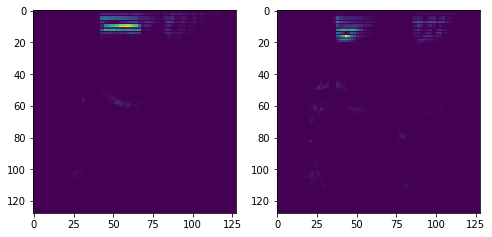

In [75]:
us_sg = F.interpolate(
            polly.sg_transform(
                us_audio
            ), size = 128
        )
uk_sg = F.interpolate(
            polly.sg_transform(
                uk_audio
            ), size = 128
        )
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(us_sg[0])
fig.add_subplot(1, 2, 2)
plt.imshow(uk_sg[0])
plt.imsave('polly_accent_transfer.png')

In [ ]:
IPython.display.Audio(polly[1][2].numpy(), rate=polly[1][3])

In [47]:
class ATModel(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, batch_size):
        super(ATModel, self).__init__()
        self.batch_size = batch_size
        self.embedding_size = 1024
        self.seq_len = 8 
        self.features = int(self.embedding_size/self.seq_len)
        self.hidden_size = int(self.features)
        
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=stride, padding=1
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.conv_fc = nn.Linear(768, self.embedding_size)
        
        
        self.lstm = nn.LSTM(
            input_size=self.features,
            hidden_size=self.hidden_size,
            num_layers=3,
            batch_first=True,
            bidirectional=True
        )
        
        self.lstm_fc1 = nn.Linear(self.embedding_size * 2, self.embedding_size)
        
        self.lstm_fc2 = nn.Linear(self.embedding_size, 128 * 128)
        
        
        self.deconv1 = nn.ConvTranspose2d(1, 3, 4, stride=2, padding=1)
        self.bn_dc1 = nn.BatchNorm2d(3)
        
        self.deconv2 = nn.ConvTranspose2d(3, 1, 4, stride=2, padding=1)
        self.bn_dc2 = nn.BatchNorm2d(1)
        
    def forward(self, x):
#         print('input:', x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
#         print('conv1:', x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
#         print('conv2:', x.shape)
        
        x = self.maxpool(x)
        
#         print('maxpool:', x.shape)
        x = torch.flatten(x, 1)
        x = self.conv_fc(x)
#         print('conv_fc:', x.shape)
        x = x.view(self.batch_size, self.seq_len, self.features)
#         print('x_view:', x.shape)
        x, (h_n, c_n) = self.lstm(x)
#         print('lstm:', x.shape)
#         x = x.reshape(self.batch_size, 1, 32, 32)
        x = x.reshape(self.batch_size, self.embedding_size * 2)
        
#         x = self.deconv1(x)
#         x = self.bn_dc1(x)
#         x = self.relu(x)
#         print('deconv1:', x.shape)
        
#         x = self.deconv2(x)
#         x = self.bn_dc2(x)
#         x = self.relu(x)
#         print('deconv2:', x.shape)
        x = self.lstm_fc1(x)
        x = self.relu(x)
        
        x = self.lstm_fc2(x)
        x = self.relu(x)        
#         print('lstm_fc:', x.shape)
        return x    

In [48]:
model = ATModel(in_channels=1, out_channels=3, kernel_size=3, stride=2, padding=1, batch_size=batch_size)
count_parameters(model)

20734186

In [49]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
model.train()
criterion = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

cuda:0


In [50]:
# overfit to minibatch
iter_train = iter(loader_train)

steps = 10000
img, labels = iter_train.next() # retrieve minibatch
img, labels = img.to(device), labels.to(device)

epoch_pbar = tqdm_notebook(range(steps))

for steps in epoch_pbar:
    output = model.forward(img)
    loss = criterion(output, labels.view(batch_size, -1))
    epoch_pbar.set_description("Loss: {}".format(str(loss.item())))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

KeyboardInterrupt: 

In [ ]:
epochs = 90
model.train()

writer = SummaryWriter()

epoch_pbar = tqdm_notebook(range(epochs))

for epoch in epoch_pbar:
    # training
    iter_train = iter(loader_train)
    offset = epoch * len(loader_train) # training_iter offset
    data_pbar = tqdm_notebook(range(len(loader_train)))
    train_loss = 0
    bad_batches = 0
    for data in data_pbar:
        # hack to bypass dataloading error.
        # will result in lower loss than actual (since dividing by larger number)
        try:
            img, labels = iter_train.next()
        except:
            bad_batches += 1
        img, labels = img.to(device), labels.to(device)
        output = model.forward(img)
        
        loss = criterion(output, labels.view(batch_size, -1))
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        data_pbar.set_description("Training Loss: {}".format(str(loss.item())))
        global_batch_num = offset + data
        writer.add_scalar('Loss/train', loss.item(), global_batch_num) # plotting train loss over batch_num
        train_loss += loss.item()
    print('bad_batches:', bad_batches)
    train_loss /= len(loader_train)
    print('avg train loss:', train_loss)
    scheduler.step(train_loss)
    torch.cuda.empty_cache()

bad_batches: 4
avg train loss: 0.763992409594357


bad_batches: 4
avg train loss: 0.7397641168286403


bad_batches: 4
avg train loss: 0.7300447500000398


bad_batches: 4
avg train loss: 0.7226520501077175


bad_batches: 4
avg train loss: 0.7162158016115427


bad_batches: 4
avg train loss: 0.7097487206260363


bad_batches: 4
avg train loss: 0.7038241328050693


bad_batches: 4
avg train loss: 0.6972206470866998
